In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:14pt;}
div.text_cell_render.rendered_html{font-size:14pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:14px;}
div.output {font-size:14pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:14pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:14pt;padding:5px;}
table.dataframe{font-size:14px;}
</style>
"""))

# <span style="color:red">ch4_RNN(RecurrentNeuralNetwork순환신경망)</span>
- 데이터의 순서가 중요하거나, 시계열 데이터일 경우
- 활용분야 : 번역, 음성인식, 주가예측, 농수산물가격예측
- 음성 인식, 자연어 처리(번역, 챗봇)
# 1. 문맥을 이용하여 모델만들기

In [2]:
text = """경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다"""
text1 = "겨울이 오는 날"

In [3]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text, text1])
encoded = t.texts_to_sequences([text, text1])
print(encoded)
print(t.word_index)

[[3, 4, 1, 5, 6, 7, 1, 8, 9, 1, 10, 2, 1, 11], [12, 2, 13]]
{'말이': 1, '오는': 2, '경마장에': 3, '있는': 4, '뛰고': 5, '있다': 6, '그의': 7, '법이다': 8, '가는': 9, '고와야': 10, '곱다': 11, '겨울이': 12, '날': 13}


In [4]:
t.texts_to_sequences(['경마장에 있는 말이 뛰고','겨울이 오는 날'])

[[3, 4, 1, 5], [12, 2, 13]]

In [5]:
t.texts_to_sequences(['경마장에 있는 말이 뛴다'])[0]

[3, 4, 1]

In [6]:
text = """경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다"""

In [7]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]
print(encoded)
print(t.word_index)

[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [8]:
t.word_index.items()

dict_items([('말이', 1), ('경마장에', 2), ('있는', 3), ('뛰고', 4), ('있다', 5), ('그의', 6), ('법이다', 7), ('가는', 8), ('고와야', 9), ('오는', 10), ('곱다', 11)])

In [9]:
for key, value in t.word_index.items():
    print(key, value)

말이 1
경마장에 2
있는 3
뛰고 4
있다 5
그의 6
법이다 7
가는 8
고와야 9
오는 10
곱다 11


In [10]:
# text를 학습시키기 위해,['경마장에 있는'(2,3),'경마장에 있는 말이'(2,3,1),.....]
sequences =[]
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]  # 인코딩된 문장[8, 1, 9, 10, 1, 11]
    print('원문장:',line, ', encoded된 문장:',encoded)
    for i in range(0, len(encoded)-1):   # 시작index
        for j in range(i+2, len(encoded)+1):  #  끝나는 index+1
            # print(encoded[i:j])
            sequences.append(encoded[i:j])
# sequences, len(sequences)
print('sequences와 해석')
for sequence in sequences:
    # print(sequence)
    for word_seq in sequence:
        for key, value in t.word_index.items():
            if word_seq==value:
                print("{}:{}".format(word_seq, key), end=' ')
                break
    print()

원문장: 경마장에 있는 말이 뛰고 있다 , encoded된 문장: [2, 3, 1, 4, 5]
원문장: 그의 말이 법이다 , encoded된 문장: [6, 1, 7]
원문장: 가는 말이 고와야 오는 말이 곱다 , encoded된 문장: [8, 1, 9, 10, 1, 11]
sequences와 해석
2:경마장에 3:있는 
2:경마장에 3:있는 1:말이 
2:경마장에 3:있는 1:말이 4:뛰고 
2:경마장에 3:있는 1:말이 4:뛰고 5:있다 
3:있는 1:말이 
3:있는 1:말이 4:뛰고 
3:있는 1:말이 4:뛰고 5:있다 
1:말이 4:뛰고 
1:말이 4:뛰고 5:있다 
4:뛰고 5:있다 
6:그의 1:말이 
6:그의 1:말이 7:법이다 
1:말이 7:법이다 
8:가는 1:말이 
8:가는 1:말이 9:고와야 
8:가는 1:말이 9:고와야 10:오는 
8:가는 1:말이 9:고와야 10:오는 1:말이 
8:가는 1:말이 9:고와야 10:오는 1:말이 11:곱다 
1:말이 9:고와야 
1:말이 9:고와야 10:오는 
1:말이 9:고와야 10:오는 1:말이 
1:말이 9:고와야 10:오는 1:말이 11:곱다 
9:고와야 10:오는 
9:고와야 10:오는 1:말이 
9:고와야 10:오는 1:말이 11:곱다 
10:오는 1:말이 
10:오는 1:말이 11:곱다 
1:말이 11:곱다 


In [11]:
my_len = max([len(sequence) for sequence in sequences])  # 나의 시퀀스 길이
my_len

6

In [12]:
# sequence를 훈련가능하도록 6(my_len)개 열로 조정
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences=sequences,
                                maxlen=my_len,
                                #padding='post',
                                padding='pre',  # 상황에 맞게 특별한 규칙은 없음
                                # truncating
                                )
type(padded_sequences),padded_sequences.shape, padded_sequences

(numpy.ndarray,
 (28, 6),
 array([[ 0,  0,  0,  0,  2,  3],
        [ 0,  0,  0,  2,  3,  1],
        [ 0,  0,  2,  3,  1,  4],
        [ 0,  2,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  3,  1,  4],
        [ 0,  0,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  1,  4],
        [ 0,  0,  0,  1,  4,  5],
        [ 0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0,  6,  1],
        [ 0,  0,  0,  6,  1,  7],
        [ 0,  0,  0,  0,  1,  7],
        [ 0,  0,  0,  0,  8,  1],
        [ 0,  0,  0,  8,  1,  9],
        [ 0,  0,  8,  1,  9, 10],
        [ 0,  8,  1,  9, 10,  1],
        [ 8,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  1,  9],
        [ 0,  0,  0,  1,  9, 10],
        [ 0,  0,  1,  9, 10,  1],
        [ 0,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  9, 10],
        [ 0,  0,  0,  9, 10,  1],
        [ 0,  0,  9, 10,  1, 11],
        [ 0,  0,  0,  0, 10,  1],
        [ 0,  0,  0, 10,  1, 11],
        [ 0,  0,  0,  0,  1, 11]]))

In [13]:
# 독립변수(X), 타겟변수(y)로 분리 - 타겟변수(y)만 원핫인코딩
X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
X.shape, y.shape

((28, 5), (28,))

In [14]:
# 단어 갯수
vocab_size = len(t.word_index)
# X를 임베딩작업을 할 때 input_dim
input_dim = vocab_size+1
input_dim

12

In [15]:
# 타겟변수(y)의 원핫인코딩
from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, vocab_size+1) # 12=> 나의 단어수+1
# Y

In [16]:
X.shape, Y.shape, vocab_size

((28, 5), (28, 12), 11)

- X=[0,8,1,9,10]
- 000000000000
- 000000000000
- 000000000000
- 000000000000
- 000000000000

In [17]:
# 학습 모델 생성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense  # Embedding-원핫인코딩한것을 

# 2. 모델 생성하기
model = Sequential()
# 원핫인코딩한 희소행렬을 임베딩 벡터로 변환(X=[0,8,1,9,10])
model.add(Embedding(input_dim=vocab_size+1,   # 임베딩층의 입력(원핫인코딩 dim)
                    output_dim=10,            # 임베딩층의 출력 갯수
                    input_length=X.shape[1])) # 입력 데이터 길이
model.add(SimpleRNN(32))     # 1128ppt 106슬라이드 그림 참조
model.add(Dense(12, activation='softmax'))
model.summary()
# 두번째 layer의 파라미터 1376 =(10+32)*32+32(bias)
# 3. 모델 학습 설정
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# 4. 모델 학습시키기
hist = model.fit(X, Y, epochs=300, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 10)             120       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
1/1 - 1s - loss: 2.4562 - accuracy: 0.2143 - 748ms/epoch - 748ms/step
Epoch 2/300
1/1 - 0s - loss: 2.4430 - accuracy: 0.2857 - 3ms/epoch - 3ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4292 - accuracy: 0.2857 - 3ms/epoch - 3ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4146 - accuracy: 0.2500 - 3ms/epoch - 3ms/step
Ep

Epoch 95/300
1/1 - 0s - loss: 1.4016 - accuracy: 0.6071 - 6ms/epoch - 6ms/step
Epoch 96/300
1/1 - 0s - loss: 1.3868 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 97/300
1/1 - 0s - loss: 1.3721 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 98/300
1/1 - 0s - loss: 1.3574 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 99/300
1/1 - 0s - loss: 1.3428 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 100/300
1/1 - 0s - loss: 1.3284 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 101/300
1/1 - 0s - loss: 1.3140 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 102/300
1/1 - 0s - loss: 1.2998 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 103/300
1/1 - 0s - loss: 1.2857 - accuracy: 0.6071 - 2ms/epoch - 2ms/step
Epoch 104/300
1/1 - 0s - loss: 1.2718 - accuracy: 0.6071 - 2ms/epoch - 2ms/step
Epoch 105/300
1/1 - 0s - loss: 1.2580 - accuracy: 0.6071 - 2ms/epoch - 2ms/step
Epoch 106/300
1/1 - 0s - loss: 1.2444 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 107/300
1/1 - 0s - loss: 1.2310 - accur

Epoch 198/300
1/1 - 0s - loss: 0.5407 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 199/300
1/1 - 0s - loss: 0.5367 - accuracy: 0.8214 - 2ms/epoch - 2ms/step
Epoch 200/300
1/1 - 0s - loss: 0.5327 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 201/300
1/1 - 0s - loss: 0.5288 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 202/300
1/1 - 0s - loss: 0.5249 - accuracy: 0.8214 - 2ms/epoch - 2ms/step
Epoch 203/300
1/1 - 0s - loss: 0.5211 - accuracy: 0.8214 - 2ms/epoch - 2ms/step
Epoch 204/300
1/1 - 0s - loss: 0.5173 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 205/300
1/1 - 0s - loss: 0.5135 - accuracy: 0.8571 - 3ms/epoch - 3ms/step
Epoch 206/300
1/1 - 0s - loss: 0.5098 - accuracy: 0.8571 - 3ms/epoch - 3ms/step
Epoch 207/300
1/1 - 0s - loss: 0.5062 - accuracy: 0.8571 - 4ms/epoch - 4ms/step
Epoch 208/300
1/1 - 0s - loss: 0.5025 - accuracy: 0.8571 - 2ms/epoch - 2ms/step
Epoch 209/300
1/1 - 0s - loss: 0.4990 - accuracy: 0.8571 - 2ms/epoch - 2ms/step
Epoch 210/300
1/1 - 0s - loss: 0.4954 - 

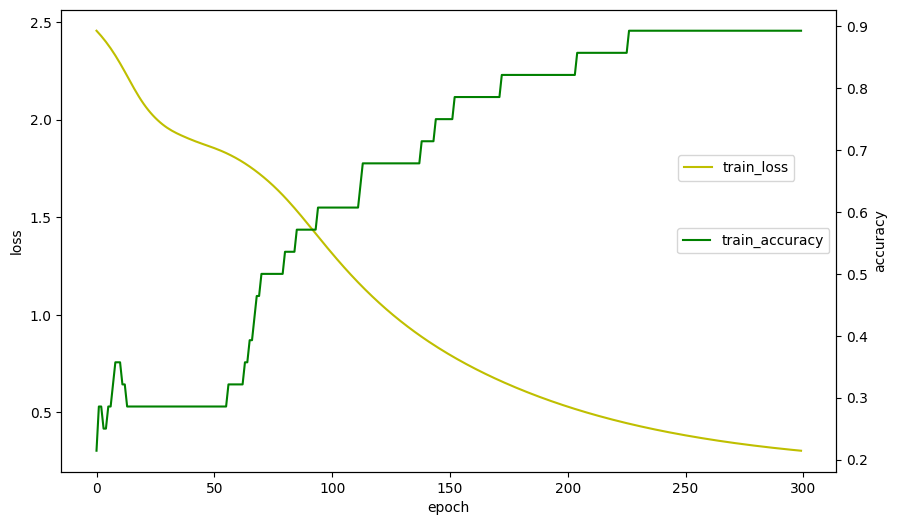

In [18]:
# 5.# 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'],'y', label='train_loss')
acc_ax = loss_ax.twinx()  # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [20]:
# 6. 모델 사용하기('경마장에'를 입력하면 '있는'을 답변하는 것을 예측)

encoded = t.texts_to_sequences(['경마장에'])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data).argmax()
print('모델이 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break

1/1 [==============================] - 0s 102ms/step
모델이 예측 결과 : 3
예측한 단어 : 있는


In [21]:
encoded = t.texts_to_sequences(['겨울은'])[0]
print('숫자로 바꾼 겨울은 :',encoded)
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
print('모델에 입력할 내용 :',input_data)

숫자로 바꾼 겨울은 : []
모델에 입력할 내용 : [[0 0 0 0 0]]


In [22]:
# 6. 모델 사용하기('사용자로 부터 입력받은 문자 -> ?)
word = input('입력단어는?')
encoded = t.texts_to_sequences([word])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data,verbose=0).argmax()
print('모델이 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break

입력단어는?겨울은
모델이 예측 결과 : 1
예측한 단어 : 말이


# 2. 다음 문맥 예측해 보기

In [23]:
# "경마장에" 이후에 단어 4개의 문맥을 만들어줘
def sentence_generation(model, current_word, n):
    print('입력된 단어:',current_word)
    for i in range(1, n+1):
        print(i,'번째 current_word :',current_word)
        encoded = t.texts_to_sequences([current_word])
        input_data = pad_sequences(encoded, maxlen=my_len-1, padding='pre')
        result = model.predict(input_data, verbose=0).argmax()
        #print(result)
        for word, index in t.word_index.items():
            if result==index:
                print("{}번째 예측 {} : {}".format(i, result, word))
                current_word = current_word + ' ' + word
                break  # 안의 for문 break

In [24]:
sentence_generation(model, "경마장에", 4)

입력된 단어: 경마장에
1 번째 current_word : 경마장에
1번째 예측 3 : 있는
2 번째 current_word : 경마장에 있는
2번째 예측 1 : 말이
3 번째 current_word : 경마장에 있는 말이
3번째 예측 4 : 뛰고
4 번째 current_word : 경마장에 있는 말이 뛰고
4번째 예측 5 : 있다
